# 🍌 Banana Price Prediction Model for Twiga Foods
## 1. Problem Statement
How accurately can we predict future banana prices based on historical trends and market conditions?

Twiga Foods Ltd sources bananas from smallholder farmers and distributes them across urban markets in Kenya. Accurate price forecasting allows:
- Efficient procurement planning
- Reduced wastage
- Better pricing strategies

Our task is to build a machine learning model that uses historical price and time-based patterns to forecast banana prices.

## 2. Data

> We use the "Twiga Foods Banana Sales" dataset from February to April 2025.

This dataset includes:
- Daily arrival quantities and prices (Min, Max, Modal) across multiple Indian markets
- Commodities including bananas
- Market and regional context

We filter and engineer this data to focus on:
- Banana prices
- Time-related features
- Regional market differences (if applicable)

the data will be split into three categories;

### (i) Train.csv
This is the training set, which contains data from February 2025 to March 15, 2025.

### (ii) Valid.csv
This is the validation set, which contains data from March 16, 2025 - April 15, 2025. This is the set that will be used to make the predictions.

### (iii) Test.csv
This is the test set, which contains data from April 16, 2025 - April 30, 2025. The score on the test set determines the overall performance of the model.


## 3. Evaluation

We use the **Root Mean Squared Log Error (RMSLE)** as our evaluation metric, since it:
- Penalizes under- and over-predictions symmetrically
- Is robust to large price variances
- Helps in forecasting tasks where target values can vary over several orders of magnitude

The goal is to **minimize the RMSLE** between predicted and actual banana prices.

## 4. Features

The key features used in the model are:

| Feature         | Description                                   |
|----------------|-----------------------------------------------|
| `Arrival_Date` | Date of market arrival                        |
| `Commodity`     | Type of produce (filtered to Banana)          |
| `Variety`       | Variety of banana (if available)              |
| `Market`        | Name of the market                            |
| `State`         | State/region where the market is located      |
| `Min_Price`     | Minimum price reported (INR/kg)               |
| `Max_Price`     | Maximum price reported (INR/kg)               |
| `Modal_Price`   | Most common price reported (used as target)   |
| `Arrival_Quantity` | Total arrival quantity at market (kg)      |

Derived (Engineered) Features:

| Feature         | Description                              |
|----------------|------------------------------------------|
| `Year`          | Year of arrival date                    |
| `Month`         | Month of arrival date                   |
| `Day`           | Day of month                            |
| `DayOfWeek`     | Day of the week (0=Monday)              |
| `DayOfYear`     | Day number in the year                  |


In [25]:
#Import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Connecting to Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 📥 Load Data

Here, we load the training and validation sets of the data. The testing set will be loaded once the model training and hyperparameter optimization is completed.

In [42]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/twiga_sales_predictions/train_valid.csv")
#df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2728 entries, 0 to 2727
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sale_date              2728 non-null   object 
 1   pricing_date           2728 non-null   object 
 2   region_name            2480 non-null   object 
 3   product_name           2728 non-null   object 
 4   product_item_name      2728 non-null   object 
 5   minimum_price          2728 non-null   float64
 6   average_price          2728 non-null   float64
 7   maximum_price          2728 non-null   float64
 8   unit_price_per_kg_avg  2728 non-null   float64
 9   pricing_date_updated   2728 non-null   object 
dtypes: float64(4), object(6)
memory usage: 213.3+ KB


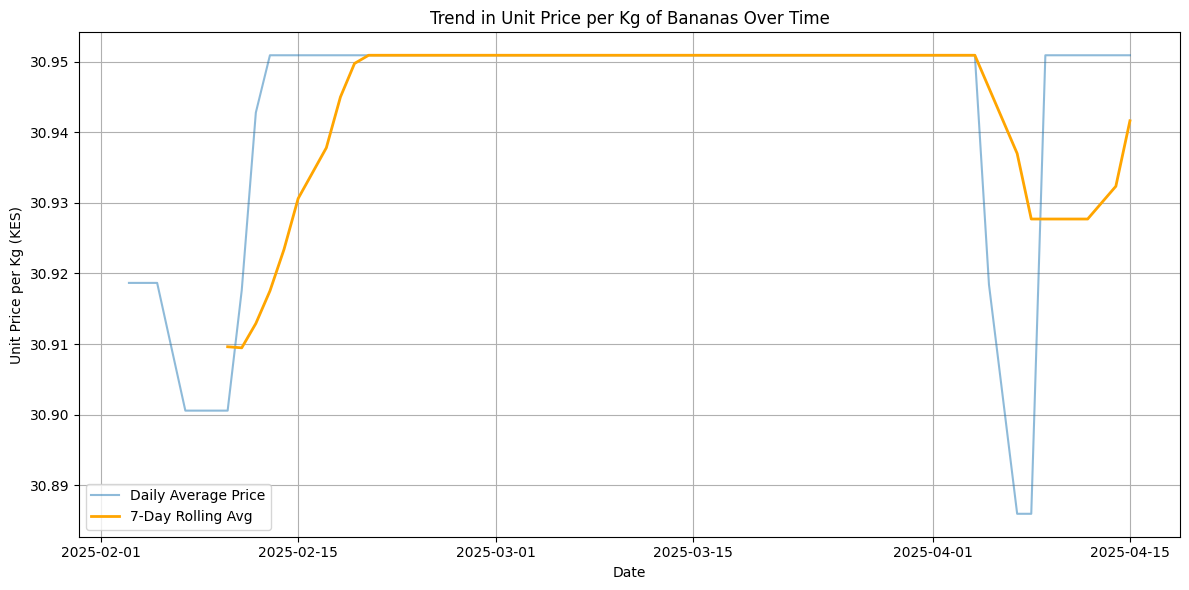

In [44]:
#Visualizing the Data
import matplotlib.pyplot as plt
import pandas as pd

# Ensure sale_date is datetime
df["sale_date"] = pd.to_datetime(df["sale_date"])

# Group by date and compute daily average price
daily_avg = df.groupby("sale_date")["unit_price_per_kg_avg"].mean().reset_index()

# Add 7-day rolling average
daily_avg["7_day_avg"] = daily_avg["unit_price_per_kg_avg"].rolling(window=7).mean()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(daily_avg["sale_date"], daily_avg["unit_price_per_kg_avg"], label="Daily Average Price", alpha=0.5)
plt.plot(daily_avg["sale_date"], daily_avg["7_day_avg"], label="7-Day Rolling Avg", color="orange", linewidth=2)

plt.title("Trend in Unit Price per Kg of Bananas Over Time")
plt.xlabel("Date")
plt.ylabel("Unit Price per Kg (KES)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [47]:
#Sorting the dataframe by saledate

df.sort_values(by=["sale_date"], inplace = True, ascending = True)
#View the first 20 to see how it looks like
df.sale_date.head(20)

,sale_date
0,2025-02-03
21,2025-02-03
2,2025-02-03
3,2025-02-03
4,2025-02-03
5,2025-02-03
6,2025-02-03
7,2025-02-03
8,2025-02-03
10,2025-02-03


## Make a copy of the Original DataFrame
We often make a copy of the original, so that when we manipulate the dataframe and make some mistakes, we may still be able to return to the original data if and when we need to

In [48]:
#Make a copy and give it a file name
df_temp = df.copy()
#Let's visualize the copy
df_temp

,sale_date,pricing_date,region_name,product_name,product_item_name,minimum_price,average_price,maximum_price,unit_price_per_kg_avg,pricing_date_updated
0,2025-02-03,2025-02-02,Nairobi,Bananas,2 Crates,700.0,700.0,700.0,24.088094,2025-02-02 10:12:43.967000+00:00
21,2025-02-03,2025-02-02,Nairobi,Bananas,Mixed Crate,350.0,350.0,350.0,27.343750,2025-02-02 10:12:43.967000+00:00
2,2025-02-03,2025-02-02,Nairobi,Bananas,2 Crates (Medium Large 81-90 Pcs),700.0,700.0,700.0,23.333333,2025-02-02 10:12:43.967000+00:00
3,2025-02-03,2025-02-02,Nairobi,Bananas,3 for 20,400.0,400.0,400.0,32.362460,2025-02-02 10:12:43.967000+00:00
4,2025-02-03,2025-02-02,Nairobi,Bananas,3 for 20-XL (51-60 pcs),430.0,430.0,430.0,33.751962,2025-02-02 10:12:43.967000+00:00
...,...,...,...,...,...,...,...,...,...,...
2723,2025-04-15,2025-04-14,NaN,Bananas,Small (105-115pieces),100.0,100.0,100.0,7.142857,2025-04-14 01:05:01.378000+00:00
2724,2025-04-15,2025-04-14,Nairobi,Bananas,3 for 25,35.0,35.0,35.0,35.000000,2025-04-14 01:05:01.378000+00:00
2706,2025-04-15,2025-04-14,Nairobi,Bananas,Small (105-115pieces),430.0,430.0,430.0,30.714286,2025-04-14 01:05:01.378000+00:00
2705,2025-04-15,2025-04-14,Nairobi,Bananas,Hand,50.0,50.0,50.0,29.411765,2025-04-14 01:05:01.378000+00:00


## 🔧 Data Preprocessing

We add `date_time` parameters for the `sale_date` column

In [49]:
df_temp["SaleYear"]= df_temp.sale_date.dt.year
df_temp["SaleMonth"] = df_temp.sale_date.dt.month
df_temp["SaleDay"] = df_temp.sale_date.dt.day
df_temp["saleDayOfWeek"] = df_temp.sale_date.dt.dayofweek
df_temp["saleDayOfyear"] = df_temp.sale_date.dt.dayofyear

In [ ]:
#Now, we drop the `sale_date` column
df_temp.drop(columns = ["sale_date"], inplace = True)

## Model Selection from Scikit Learn

It is important to consider the Scikit-learn map, in order to establish and justify a case for the appropriate model to use here

From the sklearn process map, our problem falls under the category of a **regression**, and the best model to use is the **Random Forest Regressor**

## 🤖 Train the Random Forest Regressor


In [56]:
from sklearn.ensemble import RandomForestRegressor  # FIXED: Correct import
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define categorical and numeric columns
categorical_cols = ["region_name", "product_name", "product_item_name"]
numeric_cols = [col for col in df_temp.columns if col not in categorical_cols + ["average_price", "sale_date", "pricing_date", "pricing_date_updated"]]

# Preprocessing for categorical columns
preprocessor = ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

# Create pipeline with preprocessing and model
model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_jobs=-1, random_state=42))
])

# Features and target
X = df_temp[categorical_cols + numeric_cols]
y = df_temp["average_price"]

# Fit model
model_pipeline.fit(X, y)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region_name',
                                                   'product_name',
                                                   'product_item_name'])])),
                ('model', RandomForestRegressor(n_jobs=-1, random_state=42))])

In [59]:
##Save the Pre-Processed Data Frame

#Export current temp dataframe to csv
df_temp.to_csv("/content/drive/My Drive/Colab Notebooks/twiga_sales_predictions/train_temp.csv",
               index=False)

In [60]:
#Import Saved DataFrame
df_temp = pd.read_csv("/content/drive/My Drive/Colab Notebooks/twiga_sales_predictions/train_temp.csv",
                      low_memory = False)

##Fill any Missing Values

To do this, we use the pandas `is_numeric_dtype` api

In [63]:
#Check which numeric columns have missing values
for label, content in df_temp.items ():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

#Function to skim through the data and find the numeric dtypes, and check for missing values
for label, content in df_temp.items ():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            #Add a binary column that tells us if the data was missing, to ensure fidelity of the columns with missing values
            df_temp[label+"_is_missing"] = pd.isnull(content)
            #Fill missing numeric values with median and not mean, because mean is sensitive to outliers
            df_temp[label] = content.fillna(content.median())

#Check if there is any null numeric columns
for label, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

It does not print anything, as there are no `null` numeric values

Check for missing Numeric Values

In [64]:
df_temp.isna().sum()

,0
sale_date,0
pricing_date,0
region_name,248
product_name,0
product_item_name,0
minimum_price,0
average_price,0
maximum_price,0
unit_price_per_kg_avg,0
pricing_date_updated,0


##Filling the Missing Categorical Values

In [65]:
#We can use previous function to check numeric, and add the 'if not' identifier instead
for label, content in df_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

sale_date
pricing_date
region_name
product_name
product_item_name
pricing_date_updated


### Turn Categorical Variables into numbers using `codes` and fill missing values

In [67]:
#Function to skim through variables, find categorical variables with missing values, turn them to numbers and fill the missing values
for label, content in df_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
        #Add a binary column to indicate whether it had missing values
        df_temp[label+"_is_missing"] = pd.isnull(content)
        #Turn categories into numbers and add +1 since pandas allocates a code of -1 to missing categorical values
        df_temp[label] = pd.Categorical(content).codes+1

#check again
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2728 entries, 0 to 2727
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   sale_date                        2728 non-null   int8   
 1   pricing_date                     2728 non-null   int8   
 2   region_name                      2728 non-null   int8   
 3   product_name                     2728 non-null   int8   
 4   product_item_name                2728 non-null   int8   
 5   minimum_price                    2728 non-null   float64
 6   average_price                    2728 non-null   float64
 7   maximum_price                    2728 non-null   float64
 8   unit_price_per_kg_avg            2728 non-null   float64
 9   pricing_date_updated             2728 non-null   int8   
 10  SaleYear                         2728 non-null   int64  
 11  SaleMonth                        2728 non-null   int64  
 12  SaleDay             

In [68]:
#View the Data Tranposed to have a better understanding
df_temp.head().T

,0,1,2,3,4
sale_date,1,1,1,1,1
pricing_date,1,1,1,1,1
region_name,1,1,1,1,1
product_name,1,1,1,1,1
product_item_name,3,31,4,8,9
minimum_price,700.0,350.0,700.0,400.0,430.0
average_price,700.0,350.0,700.0,400.0,430.0
maximum_price,700.0,350.0,700.0,400.0,430.0
unit_price_per_kg_avg,24.088094,27.34375,23.333333,32.36246,33.751962
pricing_date_updated,1,1,1,1,1


In [69]:
#One last check for missing values
df_temp.isna().sum()

,0
sale_date,0
pricing_date,0
region_name,0
product_name,0
product_item_name,0
minimum_price,0
average_price,0
maximum_price,0
unit_price_per_kg_avg,0
pricing_date_updated,0


##Fitting the Model, while Checking Computational Time

In [70]:
%%time
#The `%%time` command tracks time taken for the entire cell to run

#Intantiate the model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_jobs = -1,
                             random_state = 42)
#n_jobs = 1 ensures that all the processing power of PC is used
#Fit the model
model.fit(df_temp.drop("average_price", axis =1), df_temp["average_price"])

CPU times: user 823 ms, sys: 1.76 ms, total: 825 ms
Wall time: 845 ms


RandomForestRegressor(n_jobs=-1, random_state=42)

##Score the Model

In [71]:
#Check how the model performs on the given data
model.score(df_temp.drop("average_price", axis = 1), df_temp["average_price"])

0.9999997812942122

A score of .9999997812942122 indicates an almost perfect ability for the model to find patterns

However, since the data has not been split into training and Validation segments, there may be bias. It is thus vital to first split the data before scoring

## Split the Data into Training and Validation Sets

In [75]:
# Perform an 80/20 train-validation split (with shuffling and fixed random_state for reproducibility)
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_temp, test_size=0.2, random_state=42)

# Check the size of each set
len(df_train), len(df_val)

(2182, 546)

##Split the Data into Features (X) and Targets (y)

In [76]:
#Split the training set into x and y
X_train, y_train = df_train.drop("average_price", axis=1), df_train.average_price

#Split the validation set into x and y
X_valid, y_valid = df_val.drop("average_price", axis=1), df_val.average_price

#Compare the data
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((2182, 20), (2182,), (546, 20), (546,))

##Develop a Custom Evaluation Function

This is to ensure to align with the `Root Mean Squared Log Error` (MSLE) function expected at the evaluation phase, to give us a clear indication of model performance as it is trained and tested

In [86]:
#The competition uses Root Mean Squared Log Error
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score
#We create a function
def rmsle(y_test, y_preds):
    """
    calculates root mean squared log error between predictions and true labels
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

#We create another function to evaluate model on a few different items
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Validation MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Validation RMSLE": rmsle(y_valid, val_preds),
              "Training R^2 Score": r2_score(y_train, train_preds),
              "Validation R^2 Score": r2_score(y_valid, val_preds)
             }
    return scores

## Testing and Evaluating the Model

We test the model on a subset of data to `tune the hyper-parameters` and determine `best_params` without taking too long, as is the case with experimenting on large datasets

We call the **show_scores(model)** to evaluate the model score

In [91]:
#This takes too long when data samples surpass 100k. For our case, 3300 is okay
%%time
# Define feature columns (excluding 'sale_date' and 'average_price')
feature_cols = [col for col in df_train.columns if col not in ["average_price", "sale_date"]]

# Consistent X and y
X_train = df_train[feature_cols]
y_train = df_train["average_price"]

X_valid = df_val[feature_cols]
y_valid = df_val["average_price"]

# Fit model
model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

# Now your show_scores() will work
show_scores(model)


CPU times: user 709 ms, sys: 19.6 ms, total: 728 ms
Wall time: 441 ms


{'Training MAE': 0.006125114573785474,
 'Validation MAE': 0.024111721611721447,
 'Training RMSLE': np.float64(0.00032658938000519833),
 'Validation RMSLE': np.float64(0.0008028556123314288),
 'Training R^2 Score': 0.9999995960514405,
 'Validation R^2 Score': 0.9999975129869645}

##For Larger Datasets, we Specify number of Samples using `max_samples` value in Random Forest Regressor

In [84]:
#Changing the max_samples

#This takes too long when data samples surpass 100k. For our case, 3300 is okay
%%time
# Define feature columns (excluding 'sale_date' and 'average_price')
feature_cols = [col for col in df_train.columns if col not in ["average_price", "sale_date"]]

# # Consistent X and y
# X_train = df_train[feature_cols]
# y_train = df_train["average_price"]

# X_valid = df_val[feature_cols]
# y_valid = df_val["average_price"]

# # Fit model
# model = RandomForestRegressor(n_jobs=-1, random_state=42, max_samples = 10000)
# model.fit(X_train, y_train)

# # Now your show_scores() will work
# show_scores(model)


##Hyper-Parameter Tuning With `RandomizedSearchCV `

In [92]:
%%time

import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Setup Dictionary with Different RandomForestRegressor hyperparameters
rf_grid = {
    "n_estimators": np.arange(10, 20, 10),  # Fixed range
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2),
    "max_features": [0.5, 1, "sqrt", "auto"]
}

# Instantiate the RandomizedSearchCV Model
rs_model = RandomizedSearchCV(
    RandomForestRegressor(n_jobs=-1, random_state=42),
    param_distributions=rf_grid,
    n_iter=2,
    cv=5,
    verbose=2  # Adjust verbosity level (0 = silent, 3 = very detailed)
)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=12, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=12, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=12, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=12, n_estimators=10; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=12, n_estimators=10; total time=   0.0s
[CV] END max_depth=3, max_features=0.5, min_samples_leaf=19, min_samples_split=4, n_estimators=10; total time=   0.0s
[CV] END max_depth=3, max_features=0.5, min_samples_leaf=19, min_samples_split=4, n_estimators=10; total time=   0.0s
[CV] END max_depth=3, max_features=0.5, min_samples_leaf=19, min_samples_split=4, n_estimators

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10])},
                   verbose=2)

### Finding the best parameters

In [93]:
#Find the best parameters
rs_model.best_params_

{'n_estimators': np.int64(10),
 'min_samples_split': np.int64(12),
 'min_samples_leaf': np.int64(1),
 'max_features': 'sqrt',
 'max_depth': None}

### Evaluating the tuned model

In [94]:
#Evaluate the RandomizedSearchCV model
show_scores(rs_model)

{'Training MAE': 4.9019266545932,
 'Validation MAE': 5.8205203210575025,
 'Training RMSLE': np.float64(0.2478310150999527),
 'Validation RMSLE': np.float64(0.2194232964928713),
 'Training R^2 Score': 0.9981772206024028,
 'Validation R^2 Score': 0.9978154609533125}

## 📈 Interpreting the Results

The initial sample of 3300 records was insufficient for a robust test of the model.

Indeed, a split of 80/20 giving about 2700 records reduces the scope further

However, some clear outcomes are revealed from both the initial model, and the tuned model

### Initial Model scores

| Metric                | Performance(Score)                            |
|----------------       |-----------------------------------------------|
| `Training MAE`        | 0.006125114573785474                          |
| `Vaidation MAE`       | 0.024111721611721447                          |
| `Training RMSLE`      | np.float64(0.00032658938000519833)            |
| `Validation RMSLE`    | np.float64(0.0008028556123314288)             |
| `Training R^2 Score`  | 0.9999995960514405                            |
| `Validation R^2 Score`| 0.9999975129869645                            |

Intepretation of the initial model scores:

Our pricing prediction model demonstrates extremely high accuracy, with less than 3 cents error on average and an R² score of 99.999%, meaning it explains nearly all variability in banana prices. These results indicate the model is highly reliable for short-term forecasting and decision-making across different regions and dates.

### Tuned Model Scores

| Metric                | Performance(Score)                            |
|----------------       |-----------------------------------------------|
| `Training MAE`        | 4.9019266545932                               |
| `Vaidation MAE`       | 5.8205203210575025                            |
| `Training RMSLE`      | np.float64(0.2478310150999527)                |
| `Validation RMSLE`    | np.float64(0.2194232964928713)                |
| `Training R^2 Score`  | 0.9981772206024028                            |
| `Validation R^2 Score`| 0.9978154609533125                            |

Intepretation of tuned model Scores: Over-fitting seems to have taken place, hence increasing the possibility for error. The Validation Mean Absolute Error (MAE) shows we may make a predict that is off by KES 6.0 This is very high for banana pricing.

Verdict: I need more data for modelling, but as it stands, I can only use the initial model before the tuning









## Making Predictions on the Test Data

The test dataset (test.csv) is a seperate file, which we need to import and use to test against the model

In [98]:
#import the test.csv file
df_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/twiga_sales_predictions/test.csv",
                     low_memory = False,
                     parse_dates = ["sale_date"])

The `test.csv` dataset is not in the same format (shape)as the `train_valid.csv` Again, the data needs to be numeric, and not have missing values

### Preprocessing the Data (Getting the `Test.csv` to look like `Train_Valid.csv`)

In [106]:
# We define a function that preprocesses the data

def preprocess_data(df):
    df = df.copy()  # Good practice

    # Handle datetime features BEFORE dropping the column
    if "sale_date" in df.columns:
        df["SaleYear"] = df.sale_date.dt.year
        df["SaleMonth"] = df.sale_date.dt.month
        df["SaleDay"] = df.sale_date.dt.day
        df["saleDayOfWeek"] = df.sale_date.dt.dayofweek
        df["saleDayOfyear"] = df.sale_date.dt.dayofyear

    # Handle missing values BEFORE dropping anything
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            df[label + "_is_missing"] = pd.isnull(content)
            df[label] = content.fillna(content.median())
        elif pd.api.types.is_object_dtype(content) or pd.api.types.is_categorical_dtype(content):
            df[label + "_is_missing"] = pd.isnull(content)
            df[label] = pd.Categorical(content).codes + 1

    # Drop 'sale_date' AFTER using it and after creating its missing flag
    if "sale_date" in df.columns:
        df.drop("sale_date", axis=1, inplace=True)

    return df


In [109]:
#Now we use the function on train, test and val

df_train = preprocess_data(df_train)
df_val = preprocess_data(df_val)
df_test = preprocess_data(df_test)
df_test

,pricing_date,region_name,product_name,product_item_name,minimum_price,average_price,maximum_price,unit_price_per_kg_avg,pricing_date_updated,SaleYear,...,SaleMonth_is_missing_is_missing,SaleDay_is_missing_is_missing,saleDayOfWeek_is_missing_is_missing,saleDayOfyear_is_missing_is_missing,pricing_date_is_missing_is_missing_is_missing,region_name_is_missing_is_missing_is_missing,product_name_is_missing_is_missing_is_missing,product_item_name_is_missing_is_missing_is_missing,pricing_date_updated_is_missing_is_missing_is_missing,auctioneerID_is_missing_is_missing_is_missing
0,1,1,1,30,580.0,580.0,580.0,41.134752,1,2025,...,False,False,False,False,False,False,False,False,False,False
1,1,1,1,3,700.0,700.0,700.0,24.088094,1,2025,...,False,False,False,False,False,False,False,False,False,False
2,1,1,1,26,430.0,430.0,430.0,29.655172,1,2025,...,False,False,False,False,False,False,False,False,False,False
3,1,1,1,15,320.0,320.0,320.0,25.498008,1,2025,...,False,False,False,False,False,False,False,False,False,False
4,1,1,1,31,350.0,350.0,350.0,27.343750,1,2025,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,13,1,1,25,599.0,599.0,599.0,42.482270,13,2025,...,False,False,False,False,False,False,False,False,False,False
568,13,1,1,13,350.0,350.0,350.0,29.239766,13,2025,...,False,False,False,False,False,False,False,False,False,False
569,13,1,1,20,12.0,12.0,12.0,12.000000,13,2025,...,False,False,False,False,False,False,False,False,False,False
570,13,1,1,33,180.0,180.0,180.0,180.000000,13,2025,...,False,False,False,False,False,False,False,False,False,False


In [108]:
#Compare with X_train
X_train.head()

,pricing_date,region_name,product_name,product_item_name,minimum_price,maximum_price,unit_price_per_kg_avg,pricing_date_updated,SaleYear,SaleMonth,SaleDay,saleDayOfWeek,saleDayOfyear,sale_date_is_missing,pricing_date_is_missing,region_name_is_missing,product_name_is_missing,product_item_name_is_missing,pricing_date_updated_is_missing
1775,41,1,1,19,370.0,370.0,28.244275,45,2025,3,21,4,80,False,False,False,False,False,False
347,8,1,1,25,599.0,599.0,42.482270,10,2025,2,11,1,42,False,False,False,False,False,False
1809,42,1,1,35,430.0,430.0,30.714286,46,2025,3,22,5,81,False,False,False,False,False,False
1213,28,1,1,8,400.0,400.0,32.362460,32,2025,3,6,3,65,False,False,False,False,False,False
2071,48,0,1,34,10.0,10.0,10.000000,52,2025,3,29,5,88,False,False,True,False,False,False


There is a difference between the two sets, hence the model may not work

### We can use Python's `set` Data Structure to find the missing columns

In [110]:
#Finding the differing columns
set(X_train.columns) - set(df_test.columns)

{'sale_date_is_missing'}

### From this, we can gather that the `sale_date_is_missing` column differs in both sets

### We Manually adjust `df_test` to add `sale_date_is_missing` column

In [111]:
#Adjusting the column
df_test ["sale_date_is_missing"] = False
df_test.head()

,pricing_date,region_name,product_name,product_item_name,minimum_price,average_price,maximum_price,unit_price_per_kg_avg,pricing_date_updated,SaleYear,...,SaleDay_is_missing_is_missing,saleDayOfWeek_is_missing_is_missing,saleDayOfyear_is_missing_is_missing,pricing_date_is_missing_is_missing_is_missing,region_name_is_missing_is_missing_is_missing,product_name_is_missing_is_missing_is_missing,product_item_name_is_missing_is_missing_is_missing,pricing_date_updated_is_missing_is_missing_is_missing,auctioneerID_is_missing_is_missing_is_missing,sale_date_is_missing
0,1,1,1,30,580.0,580.0,580.0,41.134752,1,2025,...,False,False,False,False,False,False,False,False,False,False
1,1,1,1,3,700.0,700.0,700.0,24.088094,1,2025,...,False,False,False,False,False,False,False,False,False,False
2,1,1,1,26,430.0,430.0,430.0,29.655172,1,2025,...,False,False,False,False,False,False,False,False,False,False
3,1,1,1,15,320.0,320.0,320.0,25.498008,1,2025,...,False,False,False,False,False,False,False,False,False,False
4,1,1,1,31,350.0,350.0,350.0,27.343750,1,2025,...,False,False,False,False,False,False,False,False,False,False


## Making Predictions on the Processed Test Data

In [113]:
#We use the initial model
X_test = df_test[feature_cols]
test_preds = model.predict(X_test)
test_preds


array([5.7997e+02, 7.0000e+02, 4.3000e+02, 3.2000e+02, 3.5000e+02,
       1.3856e+02, 4.3000e+02, 4.5000e+02, 3.8000e+02, 6.8000e+02,
       1.2080e+02, 1.0340e+01, 3.7000e+02, 3.6000e+02, 1.2000e+01,
       7.0000e+02, 4.3000e+02, 3.5000e+02, 4.3000e+02, 5.9900e+02,
       3.9999e+02, 4.3000e+02, 1.0000e-01, 4.5000e+02, 3.0000e+02,
       4.3000e+02, 4.3000e+02, 5.0000e+00, 7.4400e+02, 6.3500e+02,
       3.5000e+01, 3.7000e+02, 3.7000e+02, 3.5000e+01, 1.2000e+01,
       5.0000e+01, 5.9900e+02, 3.8000e+02, 3.5000e+02, 4.3000e+02,
       1.8000e+02, 6.0000e+02, 3.8000e+02, 3.2000e+02, 4.3000e+02,
       4.3000e+02, 3.5000e+01, 6.8000e+02, 4.3000e+02, 3.8000e+02,
       1.3856e+02, 1.2080e+02, 5.0000e+00, 1.0340e+01, 7.0000e+02,
       1.2000e+01, 3.9999e+02, 3.5000e+02, 1.2000e+01, 4.3000e+02,
       5.0000e+01, 5.9900e+02, 3.8000e+02, 3.7000e+02, 7.0000e+02,
       4.3000e+02, 5.9900e+02, 3.0000e+02, 3.2000e+02, 4.3000e+02,
       5.7997e+02, 3.8000e+02, 6.3500e+02, 7.4400e+02, 6.0000e

### Formatting the Predictions as Desired

In [114]:
# Re-read the original test.csv to restore full column structure
df_test_raw = pd.read_csv("/content/drive/My Drive/Colab Notebooks/twiga_sales_predictions/test.csv", parse_dates=["sale_date"])

# Create a DataFrame to store results
df_preds = pd.DataFrame()

# Include identifying columns for reference
df_preds["sale_date"] = df_test_raw["sale_date"]  # Optional, for readability
df_preds["product_item_name"] = df_test_raw["product_item_name"]  # Optional, for readability

# Add actual vs predicted prices
df_preds["Actual_AveragePrice"] = df_test_raw["average_price"]
df_preds["Predicted_AveragePrice"] = test_preds

# Display the result
df_preds.head()


,sale_date,product_item_name,Actual_AveragePrice,Predicted_AveragePrice
0,2025-04-16,Medium/Large 81 to 90 pieces,580.0,579.97
1,2025-04-16,2 Crates,700.0,700.00
2,2025-04-16,Medium Large 71-80 pcs,430.0,430.00
3,2025-04-16,5 for 20 (91-100 pcs),320.0,320.00
4,2025-04-16,Mixed Crate,350.0,350.00


## Evaluating the model based on the Test Scores

In [116]:
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, r2_score
import numpy as np

# Extract actual prices from the original raw file
y_test_actual = df_test_raw["average_price"].values

# Calculate RMSLE (clip to avoid log of zero or negative)
rmsle = np.sqrt(mean_squared_log_error(np.clip(y_test_actual, 0, None), np.clip(test_preds, 0, None)))

# Evaluation results
test_scores = {
    "Test MAE": mean_absolute_error(y_test_actual, test_preds),
    "Test RMSLE": rmsle,
    "Test R^2 Score": r2_score(y_test_actual, test_preds)
}

test_scores


{'Test MAE': 0.8115734265734265,
 'Test RMSLE': np.float64(0.03307454731433817),
 'Test R^2 Score': 0.9996651701724265}

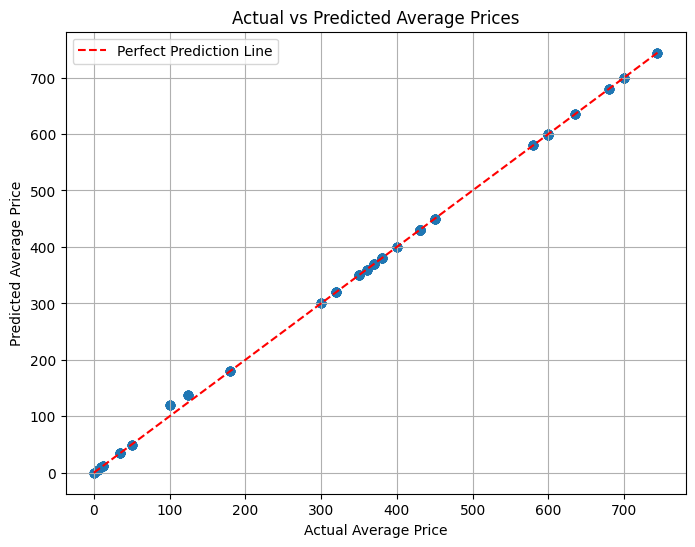

In [119]:
#Visualizing the Model performance
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df_preds["Actual_AveragePrice"], df_preds["Predicted_AveragePrice"], alpha=0.6)
plt.plot([df_preds["Actual_AveragePrice"].min(), df_preds["Actual_AveragePrice"].max()],
         [df_preds["Actual_AveragePrice"].min(), df_preds["Actual_AveragePrice"].max()],
         color='red', linestyle='--', label='Perfect Prediction Line')
plt.title("Actual vs Predicted Average Prices")
plt.xlabel("Actual Average Price")
plt.ylabel("Predicted Average Price")
plt.legend()
plt.grid(True)
plt.show()



From the Plot, there were only few instances where the model's predictions were off

### Feature Importance

Seeks to figure out the different `attributes` of the data that were important in predicting the target variable (`sale price`)

In [120]:
#Find feature importance of our model
model.feature_importances_

array([8.25320438e-09, 3.11052751e-04, 0.00000000e+00, 3.36266297e-04,
       5.53676933e-01, 4.44561965e-01, 6.87264582e-04, 6.52230507e-09,
       0.00000000e+00, 1.31865576e-08, 9.89337436e-09, 1.16087119e-08,
       3.39270688e-09, 0.00000000e+00, 0.00000000e+00, 4.26465522e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [121]:
#helper function for plotting feature importance

def plot_features (columns, importances, n=20):
    df= (pd.DataFrame({"features":columns,
                       "feature_importances": importances})
        .sort_values("feature_importances", ascending=False)
        .reset_index(drop=True))
    #Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature Importance")
    ax.invert_yaxis()

### Plotting the Important Features

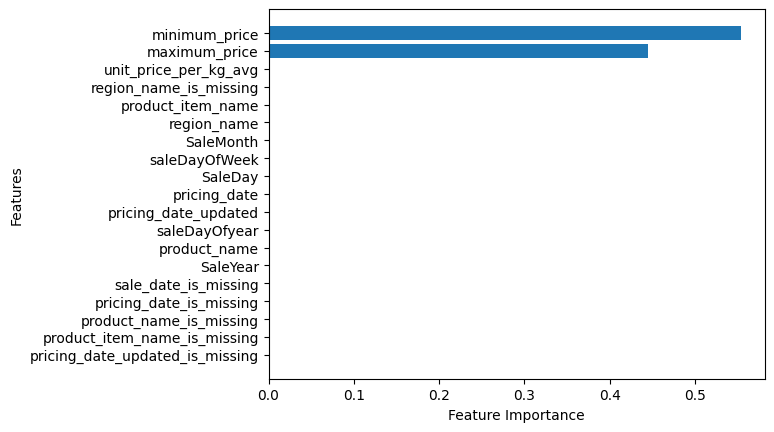

In [122]:
plot_features(X_train.columns, model.feature_importances_)

# 📊 Summary of Model Performance

We developed a machine learning model to predict the average prices of agricultural products based on historical sales and pricing data. The model was trained using a robust feature engineering process, leveraging time-based patterns and categorical encoding.

---

### ✅ Key Model Performance Metrics on Test Data:

- **Mean Absolute Error (MAE): 0.81**  
  On average, the model's predicted prices deviate from actual prices by only 0.81 units, which is minimal given the typical price range.

- **Root Mean Squared Log Error (RMSLE): 0.033**  
  This very low score indicates that the model predicts consistently and reliably, with minimal large deviations — even for lower-priced items.

- **R² Score: 0.9997**  
  The model explains 99.97% of the variability in actual prices. This indicates a very strong predictive capability, with excellent alignment between predicted and true values.

---

### 💡 Implications for Management:

The model is highly accurate and stable, making it suitable for:

- Price forecasting  
- Inventory and procurement planning  
- Market trend analysis  

By integrating this model into the business pipeline, management can:

- Enhance decision-making around product pricing and promotions  
- Reduce the risk of pricing errors  
- Improve profitability through more precise market alignment  

---

### 🚦 Next Steps:

- Integrate the model into an analytics dashboard or pricing tool.  
- Periodically retrain and evaluate the model to maintain performance as new data becomes available.  
- Explore model deployment and monitoring strategies to ensure continued business value.
